In [1]:
!pip install piqa

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import Tensor
from piqa import MS_SSIM
import torch.optim as optim
import random

In [3]:
class MSSSIM_Loss(MS_SSIM):
    def __init__(self,
                 window_size: int = 11,
                 sigma: float = 1.5,
                 n_channels: int = 3,
                 weights: Tensor = None,
                 reduction: str = 'mean',
                 padding: bool = False,
                 value_range: float = 1.0,
                 k1: float = 0.01,
                 k2: float = 0.03):

        kwargs = {
            'padding': padding,
            'value_range': value_range,
            'k1': k1,
            'k2': k2,
        }
        super(MSSSIM_Loss, self).__init__(window_size, sigma,
                                          n_channels, weights, reduction, **kwargs)

    def forward(self, x, y):
        return 1 - super(MSSSIM_Loss, self).forward(x, y)

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Discriminator(nn.Module):
    def __init__(self, numChannels: int):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
        nn.Conv2d(numChannels, 32, 5, 1),
        #N,32,124,124
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(2, 2),
        #N,32,62,62
        nn.Conv2d(32, 64, 5, 1),
        #N,64,58,58
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(2, 2),
        #N,64,29,29
        nn.Flatten(),
        nn.Linear(29*29*64, 4*4*64),
        nn.Linear(4*4*64, 1),
        nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, latentDim: int, numChannels: int):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(latentDim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 16*16*128),
            nn.ReLU(),
            nn.BatchNorm1d(16*16*128),
            nn.Unflatten(1, (128, 16, 16)),
            #N,128,16,16
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            #N,64,32,32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            #N,32,64,64
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, numChannels, 4, 2, 1),
            #N,3,128,128
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class GAN(nn.Module):
    def __init__(self, latentDim: int, numChannels: int):
        super(GAN, self).__init__()
        self.generator = Generator(latentDim, numChannels)
        self.discriminator = Discriminator(numChannels)

    def forward(self, x):
        return self.discriminator(x)

    def generate(self, x):
        return self.generator(x)

class GANLoss(nn.Module):
    def __init__(self,
                 window_size: int = 11,
                 sigma: float = 1.5,
                 n_channels: int = 3,
                 weights: torch.Tensor = None,
                 reduction: str = 'mean',
                 padding: bool = False,
                 value_range: float = 1.0,
                 k1: float = 0.01,
                 k2: float = 0.03):
        super(GANLoss, self).__init__()
        self.discriminatorLoss = nn.BCELoss()
        self.generatorLoss = MSSSIM_Loss(window_size, sigma, n_channels, weights, reduction, padding, value_range, k1, k2)

    def forward(self, real, fake, cleanImg, fakeImg):
        realLoss = self.discriminatorLoss(real, torch.ones(real.size(0), 1, device=device))
        fakeLoss = self.discriminatorLoss(fake, torch.zeros(fake.size(0), 1, device=device))
        discriminatorLoss = (realLoss + fakeLoss) / 2

        generatorLoss = self.generatorLoss(cleanImg, fakeImg)
        return discriminatorLoss, generatorLoss

In [5]:
def add_noise(images, noise_factor=0.1, salt_prob=0.01, pepper_prob=0.01):
    noise_type = random.choice(['gaussian', 'salt_and_pepper', 'poisson'])
    if noise_type == 'gaussian':
        # print(f'{noise_type} noise with noise factor: {noise_factor} is added')
        # Add Gaussian noise
        noisy_images = images + noise_factor * torch.randn_like(images)
        noisy_images = torch.clamp(noisy_images, 0., 1.)

    elif noise_type == 'salt_and_pepper':
        # print(f'{noise_type} noise with salt_prob({salt_prob}) and pepper_prob({pepper_prob}) is added')
        # Add Salt-and-Pepper noise
        noisy_images = images.clone()
        batch_size, channels, height, width = images.shape
        total_pixels = height * width

        # Salt noise (white pixels)
        num_salt = int(salt_prob * total_pixels * batch_size)
        for _ in range(num_salt):
            x = random.randint(0, batch_size - 1)
            y = random.randint(0, height - 1)
            z = random.randint(0, width - 1)
            noisy_images[x, :, y, z] = 1.0  # Set salt pixel to white

        # Pepper noise (black pixels)
        num_pepper = int(pepper_prob * total_pixels * batch_size)
        for _ in range(num_pepper):
            x = random.randint(0, batch_size - 1)
            y = random.randint(0, height - 1)
            z = random.randint(0, width - 1)
            noisy_images[x, :, y, z] = 0.0  # Set pepper pixel to black

    elif noise_type == 'poisson':
        # print(f'{noise_type} noise is added')
        # Add Poisson noise
        noisy_images = images.clone()
        noisy_images_scaled = noisy_images * 255.0
        noisy_images_poisson = torch.poisson(noisy_images_scaled)
        noisy_images = noisy_images_poisson / 255.0
        noisy_images = torch.clamp(noisy_images, 0., 1.)

    return noisy_images, noise_type

In [69]:
dLoss = []
gLoss = []

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Squeeze-and-Excitation Block

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to add noise to images(temp), can be replaced with the actual dataset
# def add_noise(images, noise_factor=0.1):
#     noisy_images = images + noise_factor * torch.randn_like(images).to(device)
#     noisy_images = torch.clamp(noisy_images, 0., 1.)
#     return noisy_images

def train(model, dataloader, optimizer, criterion, num_epochs=5):
    model.train()
    # Training function
    glossAVG = 0
    dlossAVG = 0
    for epoch in range(num_epochs):
        avgLoss = 0
        for data in dataloader:
            optimizer.zero_grad()

            cleanImgs = data.to(device)
            noisyImgs, noiseType = add_noise(cleanImgs)
            fakeImgs = model.generate(noisyImgs)
            discrimOutput_cleanImgs = model(cleanImgs)
            discrimOutput_fakeImgs = model(fakeImgs)

            discrimLoss, GeneratorLoss = criterion(discrimOutput_cleanImgs, discrimOutput_fakeImgs, cleanImgs, fakeImgs)
            loss = discrimLoss + GeneratorLoss

            dlossAVG += discrimLoss
            glossAVG += GeneratorLoss
            avgLoss += loss.item()

            loss.backward()
            optimizer.step()

        dlossAVG = dlossAVG / len(dataloader)
        glossAVG = glossAVG / len(dataloader)
        dLoss.append(dlossAVG.item())
        gLoss.append(glossAVG.item())
        dlossAVG = 0
        glossAVG = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avgLoss:.4f}')

# Visualization function
def visualize_results(model, testData ,num_images=3):  # Reduced to visualize 3 images
    model.eval()
    # can be replaced with the actual dataset
    # test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
    test_loader = DataLoader(testData, batch_size=1, shuffle=True)

    plt.figure(figsize=(6, 5))
    for i, clean_image in enumerate(test_loader):
        clean_image = clean_image.to(device)
        if i >= num_images:
            break
        noisy_image,_ = add_noise(clean_image)
        with torch.no_grad():
            denoised_image = model.generate(noisy_image)
        crit = MSSSIM_Loss(window_size=8).to(device)
        print(crit(clean_image,denoised_image))
        # Plotting
        plt.subplot(3, num_images, i + 1)
        plt.imshow(clean_image[0].permute(1, 2, 0).to("cpu").numpy())
        plt.title("Clean Image")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy_image[0].permute(1, 2, 0).to("cpu").numpy())
        plt.title("Noisy Image")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(denoised_image[0].permute(1, 2, 0).to("cpu").numpy())
        plt.title("Denoised Image")
        plt.axis('off')

    plt.show(block=True)

# Main function to run everything
if __name__ == "__main__":
    # Hyperparameters(require further tuning afterwards)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 16
    num_epochs = 1750
    learning_rate = 5e-5

    # Data loading
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # can be replaced with the actual dataset
    # train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_dataset = torch.load("cleanImage.pt",weights_only=False)
    trainData, testData = torch.utils.data.random_split(train_dataset, [int(160*0.8), int(160*0.2)])
    # Use a subset of the training dataset for faster training
    # indices = list(range(0, trainData.shape[0]))
    # train_subset = Subset(train_dataset, indices)
    train_loader = DataLoader(trainData, batch_size=batch_size, shuffle=True)

    # Model, criterion, and optimizer
    model = GAN(3*128*128,3).to(device)
    criterion = GANLoss(window_size=8).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train(model, train_loader, optimizer, criterion, num_epochs=num_epochs)

    # Visualize results
    visualize_results(model,testData)

Epoch [1/1750], Loss: 11.6661
Epoch [2/1750], Loss: 8.2281
Epoch [3/1750], Loss: 6.5110
Epoch [4/1750], Loss: 5.8758
Epoch [5/1750], Loss: 5.4696
Epoch [6/1750], Loss: 5.1641
Epoch [7/1750], Loss: 4.8612
Epoch [8/1750], Loss: 4.5176
Epoch [9/1750], Loss: 4.3086
Epoch [10/1750], Loss: 4.0775
Epoch [11/1750], Loss: 3.8700
Epoch [12/1750], Loss: 3.6317
Epoch [13/1750], Loss: 3.5566
Epoch [14/1750], Loss: 3.4045
Epoch [15/1750], Loss: 3.3160
Epoch [16/1750], Loss: 3.2659
Epoch [17/1750], Loss: 3.2379
Epoch [18/1750], Loss: 3.0628
Epoch [19/1750], Loss: 3.0257
Epoch [20/1750], Loss: 2.8429
Epoch [21/1750], Loss: 2.8109
Epoch [22/1750], Loss: 2.7606
Epoch [23/1750], Loss: 2.6501
Epoch [24/1750], Loss: 2.5973
Epoch [25/1750], Loss: 2.5666
Epoch [26/1750], Loss: 2.4156
Epoch [27/1750], Loss: 2.4185
Epoch [28/1750], Loss: 2.3609
Epoch [29/1750], Loss: 2.3323
Epoch [30/1750], Loss: 2.2864
Epoch [31/1750], Loss: 2.1920
Epoch [32/1750], Loss: 2.3535
Epoch [33/1750], Loss: 2.2466
Epoch [34/1750], L

In [65]:
len(dLoss), len(gLoss)

(1750, 1750)

In [66]:
import numpy as np

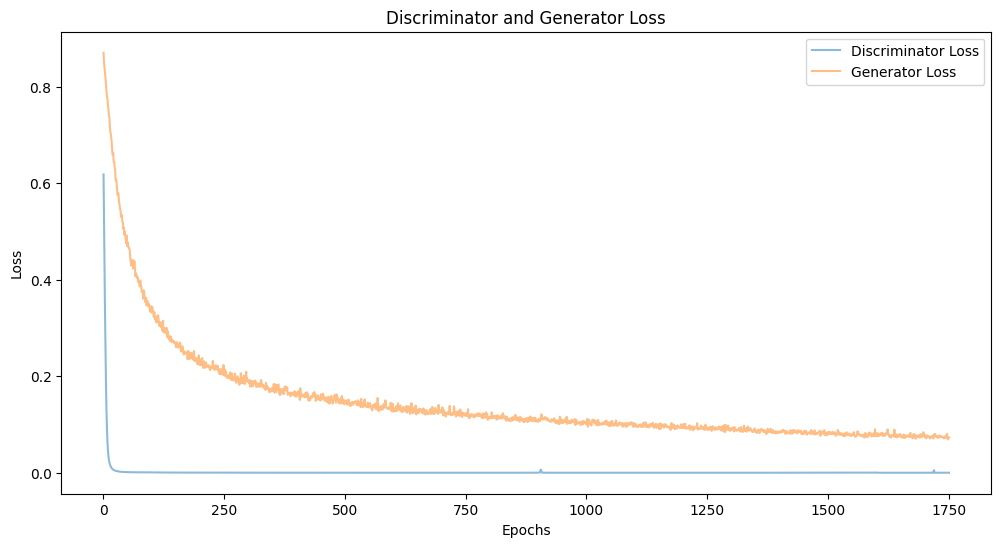

In [67]:


# Calculate running averages

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(list(range(1, len(dLoss)+1)), dLoss, label='Discriminator Loss', alpha=0.5)
plt.plot(list(range(1, len(gLoss)+1)), gLoss, label='Generator Loss', alpha=0.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss')
plt.legend()
plt.show(block=True)